In [16]:
import os
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

try:
    import pynvml
    pynvml.nvmlInit()
    GPU_AVAILABLE = True
except:
    GPU_AVAILABLE = False

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
os.makedirs("plots", exist_ok=True)
plot_counter = 1
_original_show = plt.show

def auto_save_show(*args, **kwargs):
    global plot_counter

    filename = f"plots/plot_{plot_counter}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Сохранён: {filename}")

    plot_counter += 1

    _original_show(*args, **kwargs)

plt.show = auto_save_show

In [3]:
def get_mnist_loaders(batch_size=64, root="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

In [4]:
class MediumMLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(MediumMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)

        self.out = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        return self.out(x)

In [5]:
class MediumCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MediumCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # MNIST/Fashion-MNIST (1 канал)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 28→14

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14→7

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        return self.fc2(x)

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), correct / total


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return val_loss / len(dataloader), correct / total


def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cpu")  # работаем на CPU
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "epoch_time": [],
        "cpu_load": []
    }

    total_start = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        val_loss, val_acc = validate(model, val_loader, criterion, device)

        epoch_time = time.time() - epoch_start
        history["epoch_time"].append(epoch_time)

        cpu_load = psutil.cpu_percent(interval=None)
        history["cpu_load"].append(cpu_load)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"Time: {epoch_time:.2f}s | CPU load: {cpu_load}%"
        )

    total_time = time.time() - total_start
    print(f"\nTotal training time: {total_time:.2f} seconds")

    return history

In [7]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.show()

In [8]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cpu")  # работаем на CPU
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "epoch_time": [],
        "cpu_load": []
    }

    total_start = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        epoch_time = time.time() - epoch_start
        history["epoch_time"].append(epoch_time)

        cpu_load = psutil.cpu_percent(interval=None)
        history["cpu_load"].append(cpu_load)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"Time: {epoch_time:.2f}s | CPU load: {cpu_load}%"
        )

    total_time = time.time() - total_start
    print(f"\nTotal training time: {total_time:.2f} seconds")

    return history


In [9]:
import psutil

def get_cpu_load():
    return psutil.cpu_percent(interval=None)


Epoch 1/5 | Train Loss: 0.2490 | Train Acc: 0.9235 | Val Loss: 0.1168 | Val Acc: 0.9641 | Time: 8.59s | CPU load: 10.8%
Epoch 2/5 | Train Loss: 0.1110 | Train Acc: 0.9684 | Val Loss: 0.1003 | Val Acc: 0.9700 | Time: 8.54s | CPU load: 35.8%
Epoch 3/5 | Train Loss: 0.0836 | Train Acc: 0.9754 | Val Loss: 0.0852 | Val Acc: 0.9752 | Time: 8.58s | CPU load: 36.9%
Epoch 4/5 | Train Loss: 0.0646 | Train Acc: 0.9810 | Val Loss: 0.0886 | Val Acc: 0.9771 | Time: 8.54s | CPU load: 35.7%
Epoch 5/5 | Train Loss: 0.0558 | Train Acc: 0.9842 | Val Loss: 0.0985 | Val Acc: 0.9741 | Time: 8.60s | CPU load: 35.6%

Total training time: 42.85 seconds
Сохранён: plots/plot_1.png


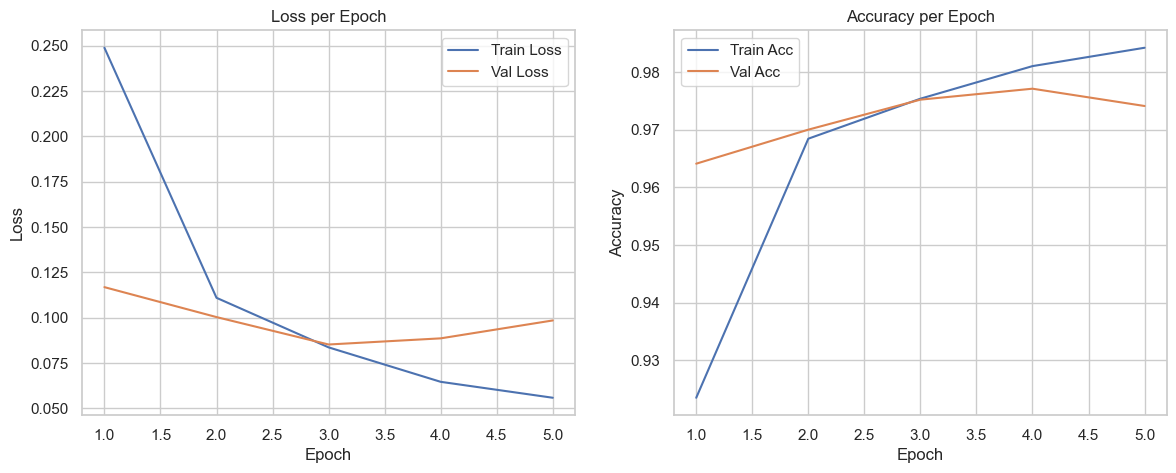

In [10]:
train_loader, val_loader = get_mnist_loaders(batch_size=64)

model = MediumMLP()

history_mlp = train_model(
    model,
    train_loader,
    val_loader,
    epochs=5,
    lr=0.001
)

plot_history(history_mlp)

Epoch 1/5 | Train Loss: 0.1440 | Train Acc: 0.9546 | Val Loss: 0.0425 | Val Acc: 0.9868 | Time: 24.03s | CPU load: 31.7%
Epoch 2/5 | Train Loss: 0.0465 | Train Acc: 0.9857 | Val Loss: 0.0277 | Val Acc: 0.9911 | Time: 24.22s | CPU load: 38.6%
Epoch 3/5 | Train Loss: 0.0328 | Train Acc: 0.9896 | Val Loss: 0.0228 | Val Acc: 0.9920 | Time: 23.92s | CPU load: 39.7%
Epoch 4/5 | Train Loss: 0.0248 | Train Acc: 0.9924 | Val Loss: 0.0268 | Val Acc: 0.9914 | Time: 23.93s | CPU load: 39.3%
Epoch 5/5 | Train Loss: 0.0193 | Train Acc: 0.9937 | Val Loss: 0.0273 | Val Acc: 0.9921 | Time: 23.98s | CPU load: 39.2%

Total training time: 120.08 seconds
Сохранён: plots/plot_2.png


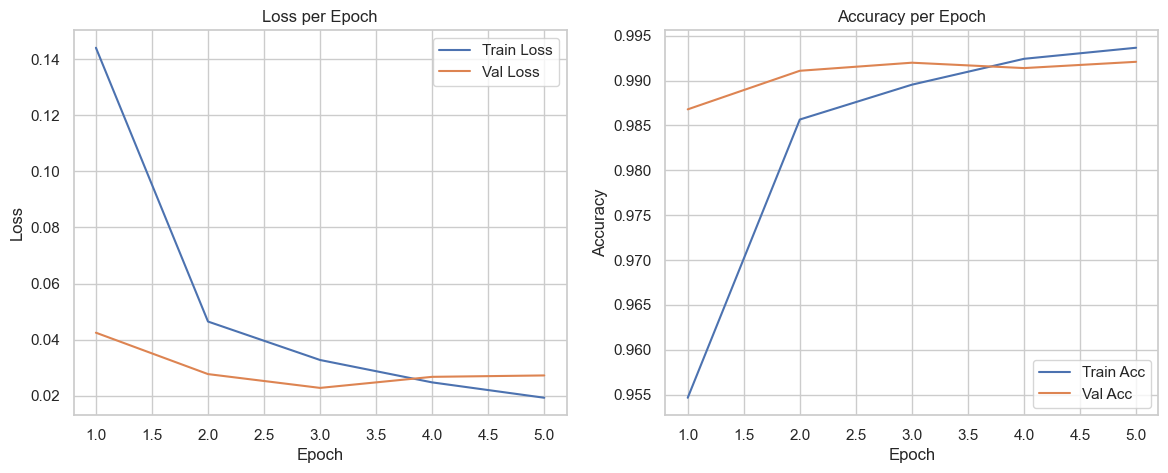

In [11]:
train_loader, val_loader = get_mnist_loaders(batch_size=64)

model = MediumCNN()

history_cnn = train_model(
    model,
    train_loader,
    val_loader,
    epochs=5,
    lr=0.001
)

plot_history(history_cnn)


In [17]:
def compare_models(history_mlp, history_cnn):
    epochs_mlp = range(1, len(history_mlp["train_loss"]) + 1)
    epochs_cnn = range(1, len(history_cnn["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_mlp, history_mlp["val_loss"], label="MLP Val Loss", marker="o")
    plt.plot(epochs_cnn, history_cnn["val_loss"], label="CNN Val Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss: MLP vs CNN")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_mlp, history_mlp["val_acc"], label="MLP Val Acc", marker="o")
    plt.plot(epochs_cnn, history_cnn["val_acc"], label="CNN Val Acc", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy: MLP vs CNN")
    plt.legend()

    plt.show()


Сохранён: plots/plot_3.png


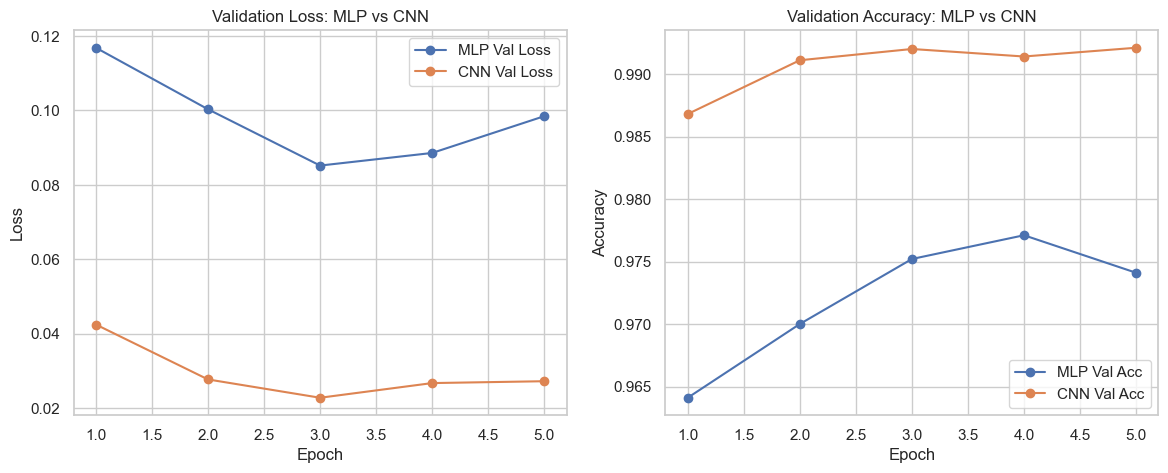

In [13]:
compare_models(history_mlp, history_cnn)


In [18]:
def summarize_results(history_mlp, history_cnn):
    summary = {
        "Model": ["MLP", "CNN"],
        "Best Val Accuracy": [
            max(history_mlp["val_acc"]),
            max(history_cnn["val_acc"])
        ],
        "Min Val Loss": [
            min(history_mlp["val_loss"]),
            min(history_cnn["val_loss"])
        ],
        "Avg Epoch Time (s)": [
            sum(history_mlp["epoch_time"]) / len(history_mlp["epoch_time"]),
            sum(history_cnn["epoch_time"]) / len(history_cnn["epoch_time"])
        ],
        "Total Time (s)": [
            sum(history_mlp["epoch_time"]),
            sum(history_cnn["epoch_time"])
        ]
    }

    df = pd.DataFrame(summary)
    return df


In [19]:
results_df = summarize_results(history_mlp, history_cnn)
results_df


,Model,Best Val Accuracy,Min Val Loss,Avg Epoch Time (s),Total Time (s)
0,MLP,0.9771,0.085194,8.569618,42.848088
1,CNN,0.9921,0.022830,24.015821,120.079107


In [17]:
def plot_cpu_load(history_mlp, history_cnn):
    epochs_mlp = range(1, len(history_mlp["cpu_load"]) + 1)
    epochs_cnn = range(1, len(history_cnn["cpu_load"]) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_mlp, history_mlp["cpu_load"], marker="o", label="MLP CPU Load")
    plt.xlabel("Epoch")
    plt.ylabel("CPU Load (%)")
    plt.title("CPU Load per Epoch (MLP)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_cnn, history_cnn["cpu_load"], marker="o", label="CNN CPU Load", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("CPU Load (%)")
    plt.title("CPU Load per Epoch (CNN)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()

    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(epochs_mlp, history_mlp["cpu_load"], marker="o", label="MLP CPU Load")
    plt.plot(epochs_cnn, history_cnn["cpu_load"], marker="o", label="CNN CPU Load")
    plt.xlabel("Epoch")
    plt.ylabel("CPU Load (%)")
    plt.title("CPU Load Comparison: MLP vs CNN")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.show()

Сохранён: plots/plot_4.png


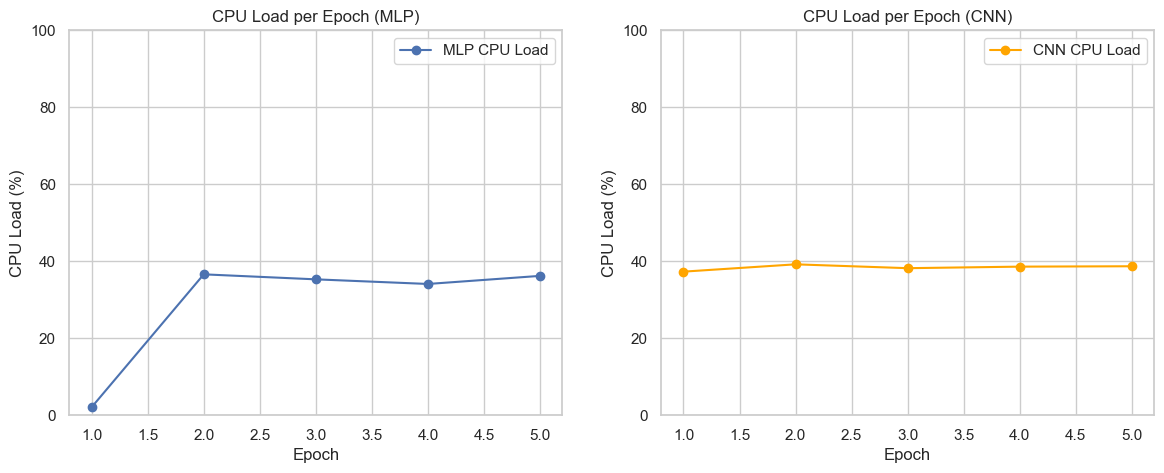

Сохранён: plots/plot_5.png


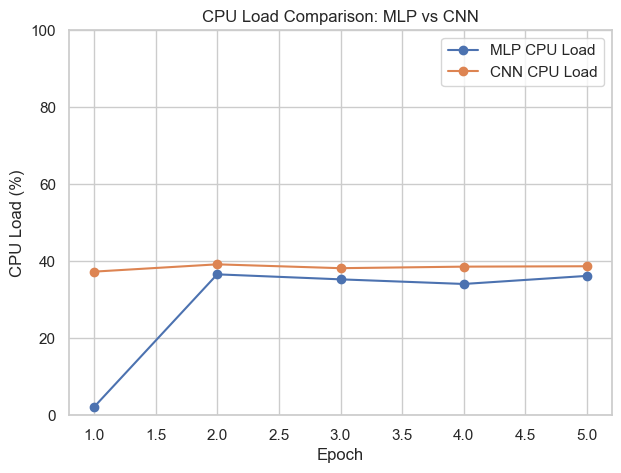

In [18]:
plot_cpu_load(history_mlp, history_cnn)


In [19]:
import matplotlib.pyplot as plt

def plot_epoch_times(history_mlp, history_cnn):
    epochs_mlp = range(1, len(history_mlp["epoch_time"]) + 1)
    epochs_cnn = range(1, len(history_cnn["epoch_time"]) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_mlp, history_mlp["epoch_time"], marker="o", label="MLP Epoch Time")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.title("Epoch Time per Epoch (MLP)")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_cnn, history_cnn["epoch_time"], marker="o", label="CNN Epoch Time", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.title("Epoch Time per Epoch (CNN)")
    plt.grid(True)
    plt.legend()

    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(epochs_mlp, history_mlp["epoch_time"], marker="o", label="MLP Epoch Time")
    plt.plot(epochs_cnn, history_cnn["epoch_time"], marker="o", label="CNN Epoch Time")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.title("Epoch Time Comparison: MLP vs CNN")
    plt.grid(True)
    plt.legend()
    plt.show()

Сохранён: plots/plot_6.png


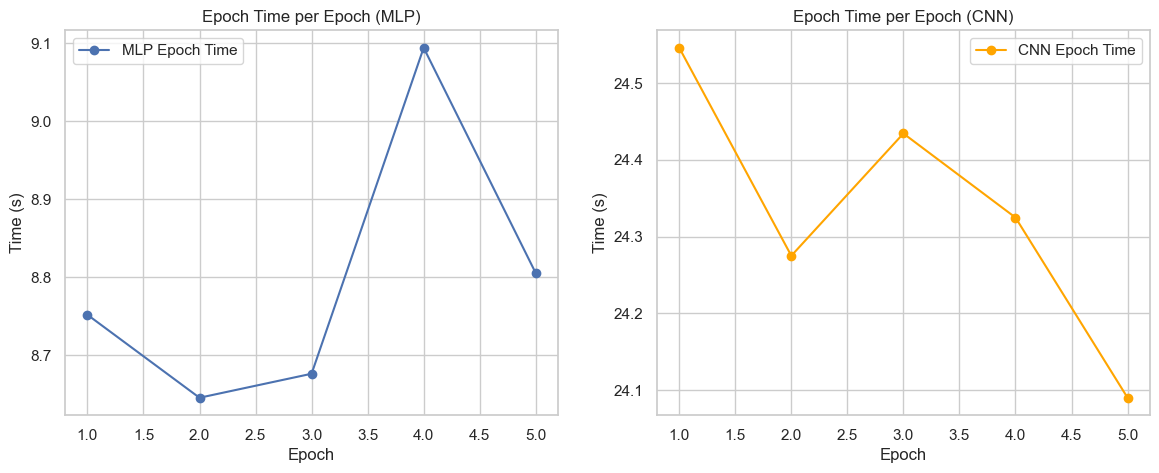

Сохранён: plots/plot_7.png


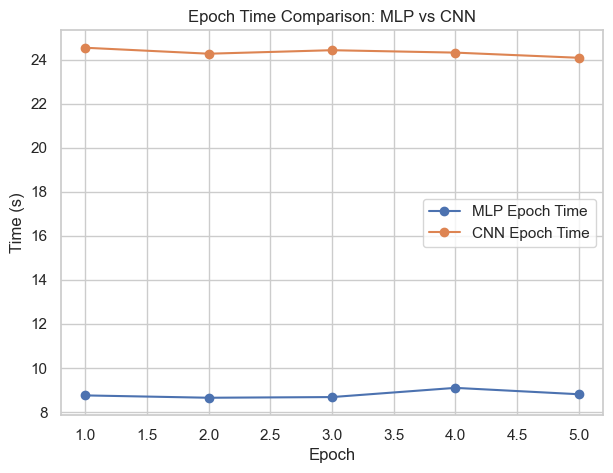

In [20]:
plot_epoch_times(history_mlp, history_cnn)


In [20]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
class AngularSpectrumLayer(nn.Module):
    def __init__(self, size=200, wavelength=7.5e-6, distance=0.03, L=0.08):
        super().__init__()
        self.size = size
        self.wavelength = wavelength
        self.distance = distance
        self.L = L

        dx = L / size
        fx = np.fft.fftfreq(size, d=dx)
        FX, FY = np.meshgrid(fx, fx)

        k = 2.0 * np.pi / wavelength
        H = np.sqrt(k**2 - (2*np.pi*FX)**2 - (2*np.pi*FY)**2)
        H = np.exp(1j * distance * H)
        self.H = torch.tensor(H, dtype=torch.complex64)

    def forward(self, x):
        # x: [batch, 1, 200, 200]
        x = x.squeeze(1)  # → [batch, 200, 200]
        x = torch.exp(1j * 2.0 * np.pi * x)  # фазовая модуляция

        x_fft = torch.fft.fft2(x)
        x_prop = torch.fft.ifft2(x_fft * self.H)

        return torch.abs(x_prop).unsqueeze(1)

In [22]:
class OpticalMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.opt1 = AngularSpectrumLayer()
        self.opt2 = AngularSpectrumLayer()
        self.fc = nn.Linear(200 * 200, 10)

    def forward(self, x):
        x = self.opt1(x)
        x = self.opt2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [23]:
def train_model(model, train_loader, val_loader, epochs=5, lr=0.001, device="cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "epoch_time": [],
        "cpu_load": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        start_time = time.time()
        cpu_before = psutil.cpu_percent(interval=None)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_time = time.time() - start_time
        cpu_after = psutil.cpu_percent(interval=None)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(epoch_time)
        history["cpu_load"].append(cpu_after)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.2f}s | CPU: {cpu_after}%")

    return history

In [24]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("OpticalMLP - Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("OpticalMLP - Accuracy Curve")
    plt.legend()
    plt.grid()
    plt.show()

def plot_epoch_time(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["epoch_time"], label="Epoch Time (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("OpticalMLP - Training Time per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

def plot_cpu_load(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["cpu_load"], label="CPU Load (%)")
    plt.xlabel("Epoch")
    plt.ylabel("CPU %")
    plt.title("OpticalMLP - CPU Load per Epoch")
    plt.legend()
    plt.grid()
    plt.show()


In [25]:
optical_model = OpticalMLP()
history_opt = train_model(optical_model, train_loader, val_loader, epochs=5, lr=0.001)


Epoch 1/5 | Train Loss: 16.0670 | Train Acc: 0.1313 | Val Loss: 11.7363 | Val Acc: 0.1568 | Time: 43.65s | CPU: 39.2%
Epoch 2/5 | Train Loss: 10.6822 | Train Acc: 0.2102 | Val Loss: 17.0449 | Val Acc: 0.1007 | Time: 43.89s | CPU: 38.5%
Epoch 3/5 | Train Loss: 8.5889 | Train Acc: 0.2831 | Val Loss: 12.7460 | Val Acc: 0.2675 | Time: 44.10s | CPU: 39.1%
Epoch 4/5 | Train Loss: 7.7285 | Train Acc: 0.3386 | Val Loss: 9.0601 | Val Acc: 0.4578 | Time: 44.15s | CPU: 39.2%
Epoch 5/5 | Train Loss: 7.0782 | Train Acc: 0.3738 | Val Loss: 4.0260 | Val Acc: 0.4562 | Time: 44.19s | CPU: 39.2%


Сохранён: plots/plot_4.png


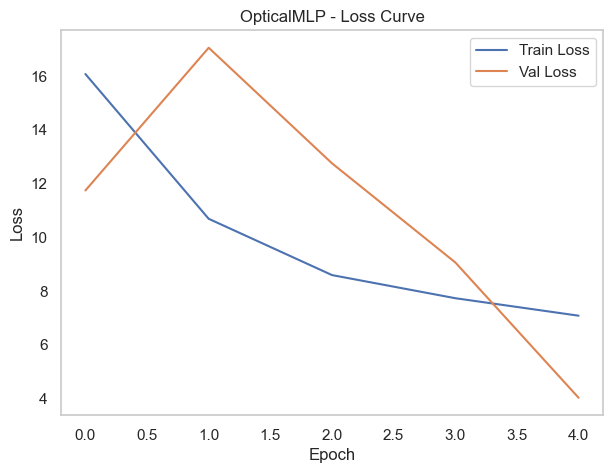

Сохранён: plots/plot_5.png


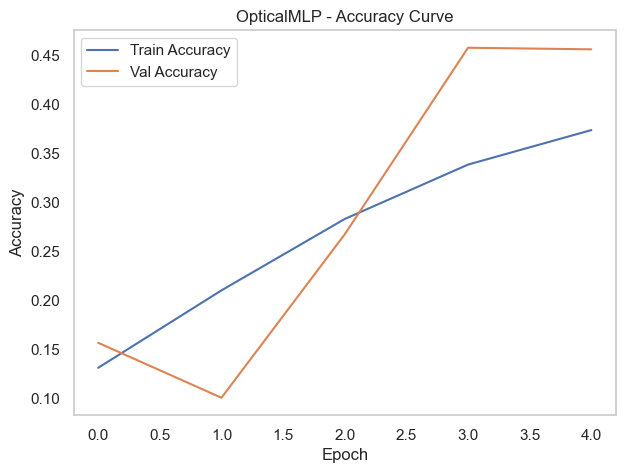

Сохранён: plots/plot_6.png


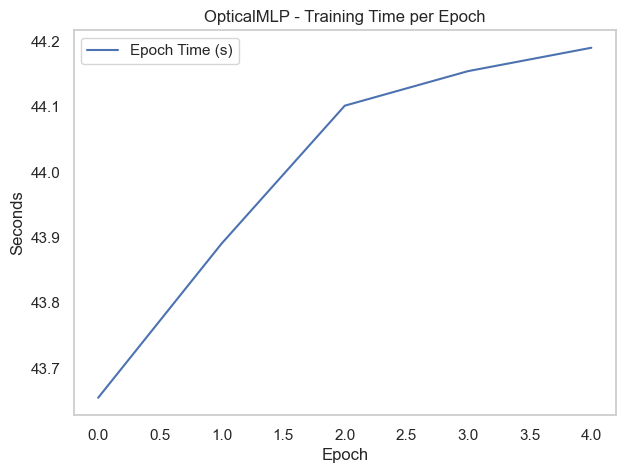

Сохранён: plots/plot_7.png


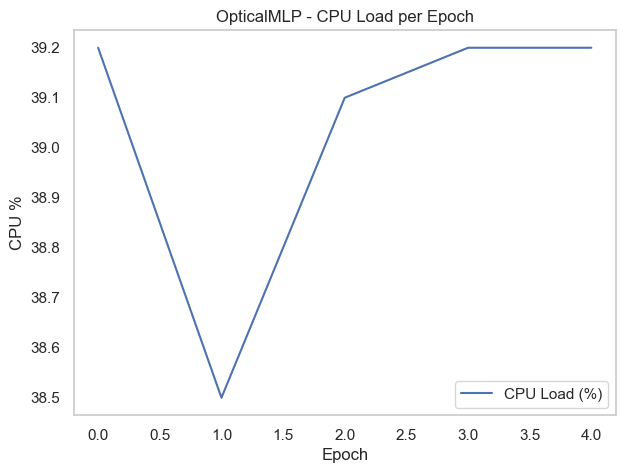

In [26]:
plot_loss(history_opt)
plot_accuracy(history_opt)
plot_epoch_time(history_opt)
plot_cpu_load(history_opt)


In [27]:
class AngularSpectrumLayer(nn.Module):
    def __init__(self, N=200, L=0.08, wavelength=7.5e-6, z=0.03, device='cpu'):
        super().__init__()
        self.N = N
        self.L = L
        self.dx = L / N
        self.lmb = wavelength
        self.z = z
        self.k = 2.0 * torch.pi / self.lmb

        x = torch.linspace(-L/2, L/2 - self.dx, N)
        fx = torch.linspace(-1/(2*self.dx), 1/(2*self.dx) - 1/L, N)
        FX, FY = torch.meshgrid(fx, fx, indexing='ij')

        H = torch.sqrt(self.k**2 - (2*torch.pi*FX)**2 - (2*torch.pi*FY)**2)
        H = torch.exp(1j * self.z * H)
        self.H = nn.Parameter(H.to(device), requires_grad=False)

    def forward(self, x):

        if not torch.is_complex(x):
            x = x.to(torch.complex64)

        x_ft = torch.fft.fft2(x)
        x_ft = x_ft * torch.fft.fftshift(self.H)
        u1 = torch.fft.ifft2(x_ft)
        out = torch.abs(u1)
        return out



class OpticalCNN(nn.Module):
    def __init__(self, num_classes=10, device='cpu'):
        super().__init__()
        self.device = device

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.resize_to_optical = T.Resize((200, 200))

        self.opt_layer = AngularSpectrumLayer(N=200, device=device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 200 * 200, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.mean(x, dim=1, keepdim=True)
        x = self.resize_to_optical(x)
        x = self.opt_layer(x)
        x = self.classifier(x)
        return x

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_opt_cnn = OpticalCNN(num_classes=10, device=device).to(device)

history_opt_cnn = train_model(
    model_opt_cnn,
    train_loader,
    val_loader,
    epochs=5,
    lr=0.001
)

Epoch 1/5 | Train Loss: 0.4254 | Train Acc: 0.8668 | Val Loss: 0.2596 | Val Acc: 0.9216 | Time: 254.63s | CPU: 38.9%
Epoch 2/5 | Train Loss: 0.2256 | Train Acc: 0.9309 | Val Loss: 0.1980 | Val Acc: 0.9398 | Time: 251.16s | CPU: 39.7%
Epoch 3/5 | Train Loss: 0.1831 | Train Acc: 0.9433 | Val Loss: 0.1889 | Val Acc: 0.9389 | Time: 249.76s | CPU: 39.9%
Epoch 4/5 | Train Loss: 0.1598 | Train Acc: 0.9498 | Val Loss: 0.1362 | Val Acc: 0.9594 | Time: 256.52s | CPU: 39.9%
Epoch 5/5 | Train Loss: 0.1447 | Train Acc: 0.9555 | Val Loss: 0.1384 | Val Acc: 0.9591 | Time: 270.72s | CPU: 40.6%


In [29]:
def plot_loss(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("OpticalCNN — Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("OpticalCNN — Accuracy Curve")
    plt.legend()
    plt.grid()
    plt.show()

def plot_epoch_time(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["epoch_time"], label="Epoch Time (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("OpticalCNN — Training Time per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

def plot_cpu_load(history):
    plt.figure(figsize=(7,5))
    plt.plot(history["cpu_load"], label="CPU Load (%)")
    plt.xlabel("Epoch")
    plt.ylabel("CPU %")
    plt.title("OpticalCNN — CPU Load per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

Сохранён: plots/plot_12.png


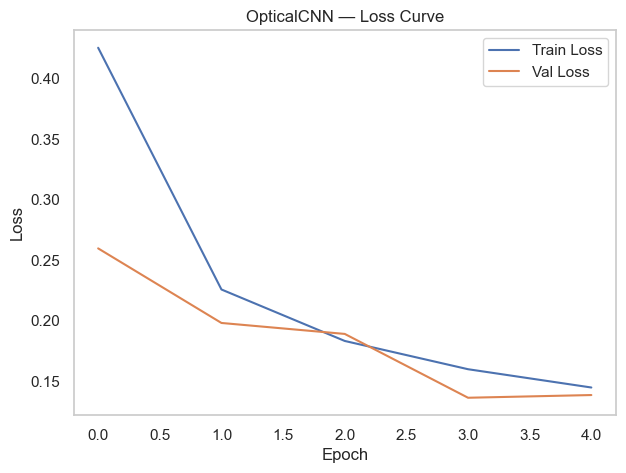

Сохранён: plots/plot_13.png


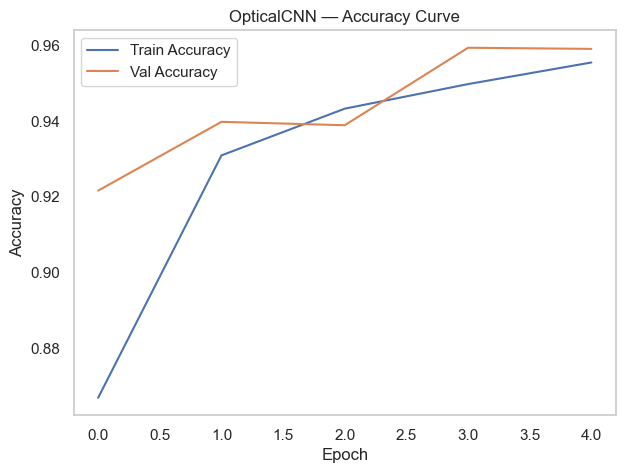

Сохранён: plots/plot_14.png


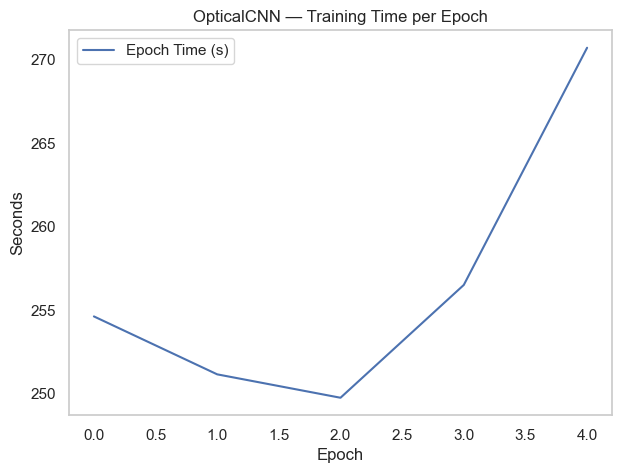

Сохранён: plots/plot_15.png


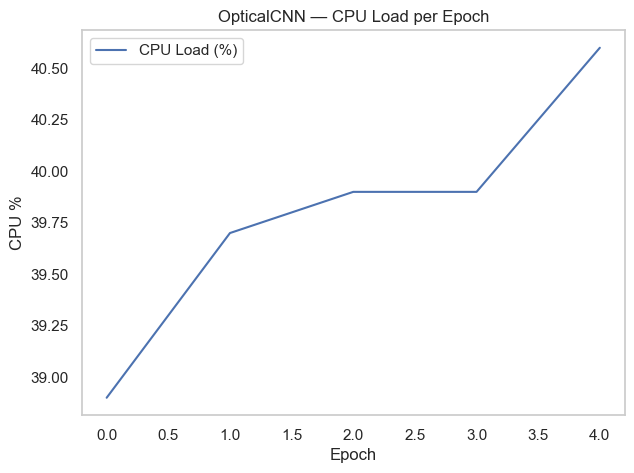

In [30]:
plot_loss(history_opt_cnn)
plot_accuracy(history_opt_cnn)
plot_epoch_time(history_opt_cnn)
plot_cpu_load(history_opt_cnn)


In [31]:
def plot_loss_all(histories, labels):
    plt.figure(figsize=(10,6))
    for hist, label in zip(histories, labels):
        plt.plot(hist["train_loss"], label=f"{label} Train Loss")
        plt.plot(hist["val_loss"], linestyle="--", label=f"{label} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Comparison — MLP / CNN / OpticalMLP / OpticalCNN")
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracy_all(histories, labels):
    plt.figure(figsize=(10,6))
    for hist, label in zip(histories, labels):
        plt.plot(hist["train_acc"], label=f"{label} Train Acc")
        plt.plot(hist["val_acc"], linestyle="--", label=f"{label} Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison — MLP / CNN / OpticalMLP / OpticalCNN")
    plt.legend()
    plt.grid()
    plt.show()

def plot_time_all(histories, labels):
    plt.figure(figsize=(10,6))
    for hist, label in zip(histories, labels):
        plt.plot(hist["epoch_time"], label=f"{label} Epoch Time")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Epoch Time Comparison — MLP / CNN / OpticalMLP / OpticalCNN")
    plt.legend()
    plt.grid()
    plt.show()

def plot_cpu_all(histories, labels):
    plt.figure(figsize=(10,6))
    for hist, label in zip(histories, labels):
        plt.plot(hist["cpu_load"], label=f"{label} CPU Load")
    plt.xlabel("Epoch")
    plt.ylabel("CPU %")
    plt.title("CPU Load Comparison — MLP / CNN / OpticalMLP / OpticalCNN")
    plt.legend()
    plt.grid()
    plt.show()

Сохранён: plots/plot_16.png


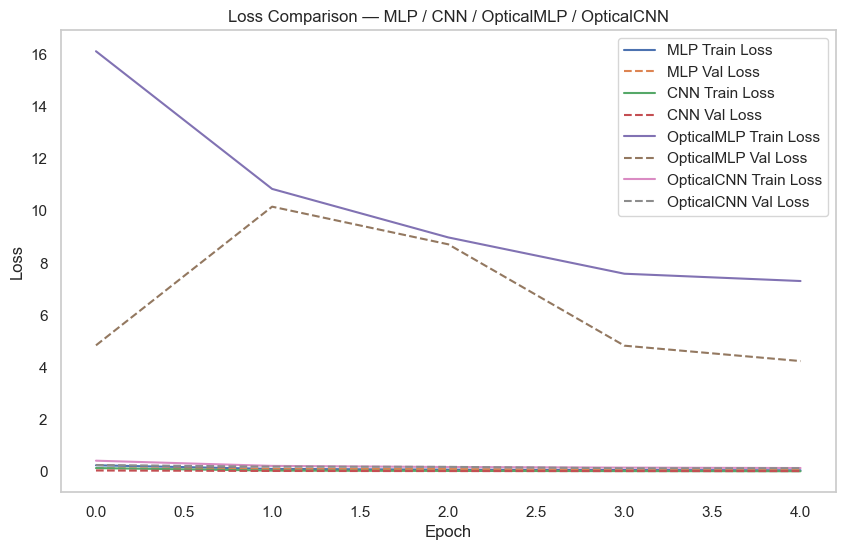

Сохранён: plots/plot_17.png


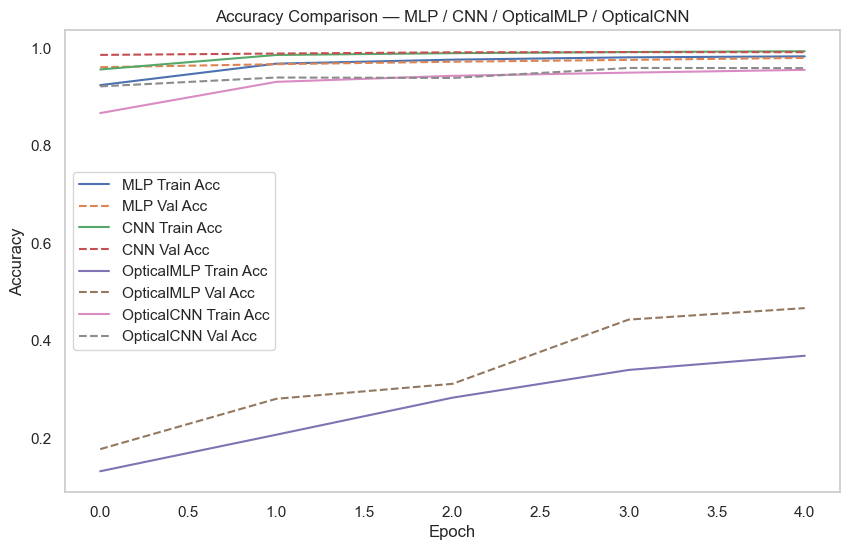

Сохранён: plots/plot_18.png


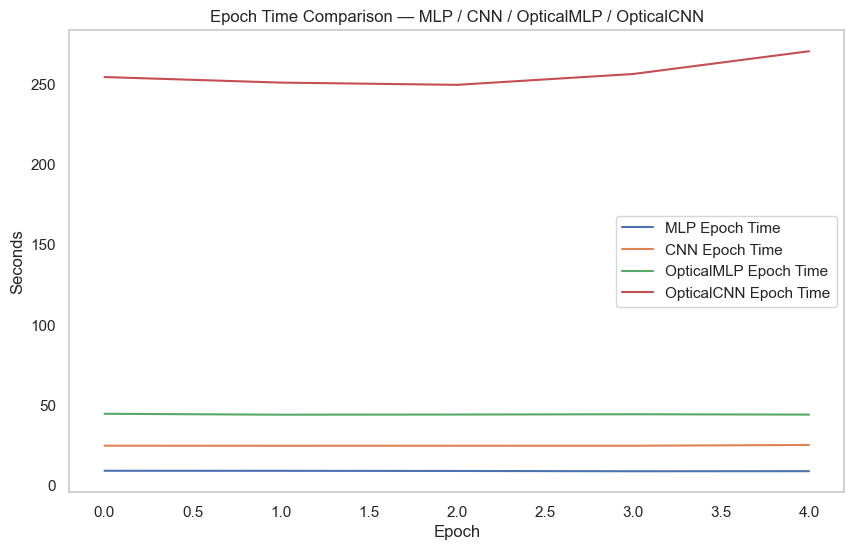

Сохранён: plots/plot_19.png


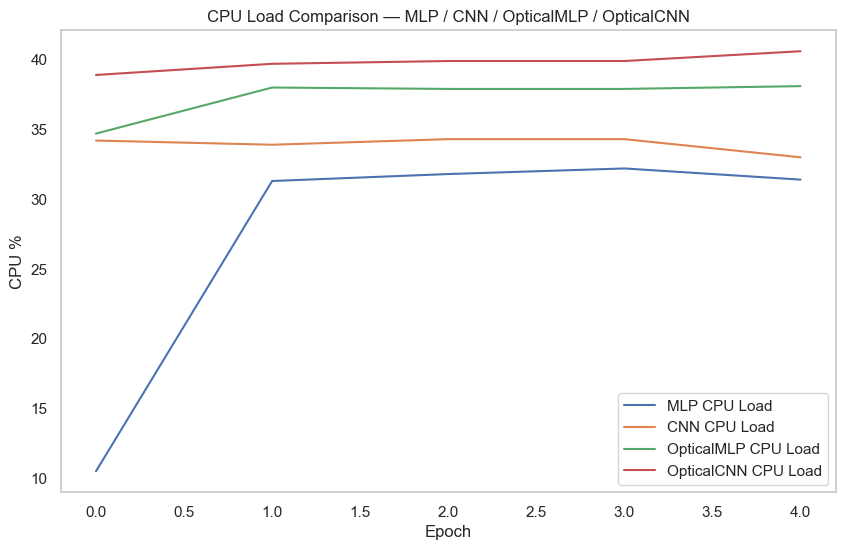

In [32]:
histories = [history_mlp, history_cnn, history_opt, history_opt_cnn]
labels = ["MLP", "CNN", "OpticalMLP", "OpticalCNN"]

plot_loss_all(histories, labels)
plot_accuracy_all(histories, labels)
plot_time_all(histories, labels)
plot_cpu_all(histories, labels)
